Online material used to develop this solution
- https://towardsdatascience.com/predicting-loan-repayment-5df4e0023e92
- https://www.kaggle.com/euclides/raladores-101?scriptVersionId=5799479
- https://scikit-learn.org
- https://imbalanced-learn.readthedocs.io/en/stable/api.html

In [3]:
%matplotlib inline
import numpy as np # makes Python better than MATLAB for array manipulation
import pandas as pd # For reading and putting our CSV data in a shape suitable for processing 

# Traditional ML library
import sklearn 
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.ensemble import BalancedBaggingClassifier,BalancedRandomForestClassifier # ML for imbalanced problems
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

import matplotlib.pylab as plt # for plotting


# Features/columns to be removed for several reasons: ethical irrelevant feature, etc
to_remove = ["job_name", "reason","channel","n_issues","ok_since","zip","gender"] 

# Read train and test data and drop columns
df_train = pd.read_csv("../Data/Traditional-ML/puzzle_train_dataset.csv").set_index("ids").drop(to_remove, axis=1)
df_test = pd.read_csv("../Data/Traditional-ML/puzzle_test_dataset.csv").set_index("ids").drop(to_remove, axis=1)

print("Nb. of train samples: %d" %df_train.shape[0])
print("Number of test samples:  %d" %df_test.shape[0])
print("Nb. features: %d" %(df_train.shape[1]-1))

# Remove samples with missing labels
df_train = df_train[pd.notnull(df_train['default'])]
df_train["default"] = df_train["default"].astype("int")

print("Nb. of train samples after removing samples with no label: %d" %df_train.shape[0])
print("Classes ratio (False/True): %f" %((df_train["default"] == 0).sum()/(df_train["default"] == 1).sum()))


# Dataset information
feats_info = pd.concat([df_train.isnull().sum(), df_train.dtypes, df_train.T.apply(lambda x: x.nunique(), axis=1)], axis=1)
feats_info.columns = ["Missing","Type","Unique"]
print("\n Dataset Information (missing features, data type, unique values)")
print(feats_info)

Nb. of train samples: 64592
Number of test samples:  35000
Nb. features: 18
Nb. of train samples after removing samples with no label: 59966
Classes ratio (False/True): 5.305573

 Dataset Information (missing features, data type, unique values)
                    Missing     Type  Unique
default                   0    int32       2
score_1                   0   object       7
score_2                   0   object      35
score_3                   0  float64      87
score_4                   0  float64   59966
score_5                   0  float64   59966
score_6                   0  float64   59966
risk_rate                 0  float64      81
amount_borrowed           0  float64   50484
borrowed_in_months        0  float64       2
credit_limit          18779  float64   26238
income                    0  float64   54273
sign                  18938   object      12
facebook_profile       5971   object       2
state                     0   object      50
real_state                0   objec

In [4]:
def get_encoder(df, col):
    dft = df[col].astype(str).to_frame().copy()
    dft["count"] = 1
    return dft.groupby(col).count().to_dict()["count"]
    
def encode_all(df_train, df_test, cols):
    for col in cols:
        enc = get_encoder(df_train, col)
        df_train[col] = df_train[col].astype(str).apply(lambda x: enc.get(x, -1))
        df_test[col] = df_test[col].astype(str).apply(lambda x: enc.get(x, -1))
    return df_train, df_test


# Create additional binary features flag for missing values for all features that have missing values
for col in df_test.columns:
    df_train["is_" + col + "_missing"] = df_train[col].isnull() * 1
    df_test["is_" + col + "_missing"] = df_test[col].isnull() * 1

# Represent categorical feature as a series o binary values and drop first column to avoid redundancy
df_train = pd.get_dummies(df_train, columns=['score_1','score_2','real_state'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['score_1','score_2','real_state'], drop_first=True)

encode_cols = df_train.dtypes
encode_cols = encode_cols[encode_cols == object].index.tolist()


# Encode categorical variables and replace NaN by -1
df_train, df_test = encode_all(df_train, df_test, encode_cols)
df_train, df_test = df_train.fillna(-1), df_test.fillna(-1)

# Split features and labels
X_train, y_train = df_train.drop(["default"], axis=1), df_train["default"]
X_test = df_test

In [5]:
# Print first rows of the training set
X_train.head()

,score_3,score_4,score_5,score_6,risk_rate,amount_borrowed,borrowed_in_months,credit_limit,income,sign,...,score_2_tHpS8e9F8d9zg3iOQM9tsA==,score_2_tQUTfUyeuGkhRotd+6WjVg==,score_2_vJyc9xom9v7hwFMPTIpmKw==,score_2_w1miZqhB5+RSamEQJa0rqg==,score_2_wjdj2vxjWoDsEIk0l09ynw==,score_2_wkeCdGeu5sEv4/fjwR0aDg==,real_state_N5/CE7lSkAfB04hVFFwllw==,real_state_UX7AdFYgQh+VrVC5eIaU9w==,real_state_n+xK9CfX0bCn77lClTWviw==,real_state_nSpvDsIsslUaX6GE6m6eQA==
ids,,,,,,,,,,,,,,,,,,,,,
810e3277-619e-3154-7ba0-ebddfc5f7ea9,710.0,104.174961,0.661509,123.015325,0.43,20024.31,60.0,62386.0,59869.05,5571,...,1,0,0,0,0,0,0,0,1,0
b4118fd5-77d5-4d80-3617-bacd7aaf1a88,330.0,97.880798,0.531115,110.913484,0.23,10046.51,36.0,-1.0,46016.31,1402,...,0,0,0,0,0,0,0,0,1,0
a75638f1-4662-4f4f-044a-d649b676d85d,360.0,97.908925,0.611086,104.620791,0.30,21228.25,60.0,-1.0,48025.47,5582,...,0,0,0,0,0,1,1,0,0,0
285ce334-3602-42b3-51cb-eebfcba48a09,120.0,100.434557,0.139784,120.134718,0.15,23032.33,36.0,-1.0,46011.12,18938,...,0,1,0,0,0,0,1,0,0,0
e643bf65-9288-92f2-df13-eed631fe237c,330.0,103.774638,0.002856,104.320462,0.08,24026.29,36.0,32366.0,90026.17,5582,...,0,0,0,0,0,0,1,0,0,0


In [6]:
# Print first rows of the test set
X_test.head()

,score_3,score_4,score_5,score_6,risk_rate,amount_borrowed,borrowed_in_months,credit_limit,income,sign,...,score_2_tHpS8e9F8d9zg3iOQM9tsA==,score_2_tQUTfUyeuGkhRotd+6WjVg==,score_2_vJyc9xom9v7hwFMPTIpmKw==,score_2_w1miZqhB5+RSamEQJa0rqg==,score_2_wjdj2vxjWoDsEIk0l09ynw==,score_2_wkeCdGeu5sEv4/fjwR0aDg==,real_state_N5/CE7lSkAfB04hVFFwllw==,real_state_UX7AdFYgQh+VrVC5eIaU9w==,real_state_n+xK9CfX0bCn77lClTWviw==,real_state_nSpvDsIsslUaX6GE6m6eQA==
ids,,,,,,,,,,,,,,,,,,,,,
e4366223-7aa2-0904-7a47-66479ae46b2a,230.0,101.906686,0.677760,77.245320,0.22,21016.38,36.0,43666.0,156021.02,18938,...,0,0,0,0,0,0,1,0,0,0
c6416108-c6d7-e6be-c4b5-923dd36c8ec4,400.0,96.276632,0.278711,94.980774,0.13,1211.74,36.0,-1.0,8410.56,1402,...,0,0,0,0,0,0,1,0,0,0
a90d3929-86ec-2414-89ba-543776b0e82b,420.0,98.901695,0.894661,108.136546,0.25,6990.63,36.0,-1.0,45116.60,3499,...,0,0,0,0,0,0,1,0,0,0
c5b96a7f-389a-28d0-242d-95db05e69da0,490.0,95.975994,0.972729,126.120768,0.46,15025.67,60.0,71273.0,60029.26,2839,...,0,0,0,0,0,0,0,0,1,0
1b461faa-926d-565d-b15d-0b452968ac81,320.0,101.303601,0.234202,107.162760,0.29,7027.81,36.0,-1.0,27618.96,3499,...,0,0,0,0,0,0,0,0,1,0


(11994, 2)
AUC score on fold 0: 0.759
(11993, 2)
AUC score on fold 1: 0.762
(11993, 2)
AUC score on fold 2: 0.758
(11993, 2)
AUC score on fold 3: 0.767
(11993, 2)
AUC score on fold 4: 0.764
AUC: 0.762 +- 0.0034

Confusion matrix:
[[49804.   652.]
 [ 8197.  1313.]]

Accuracy 0.852


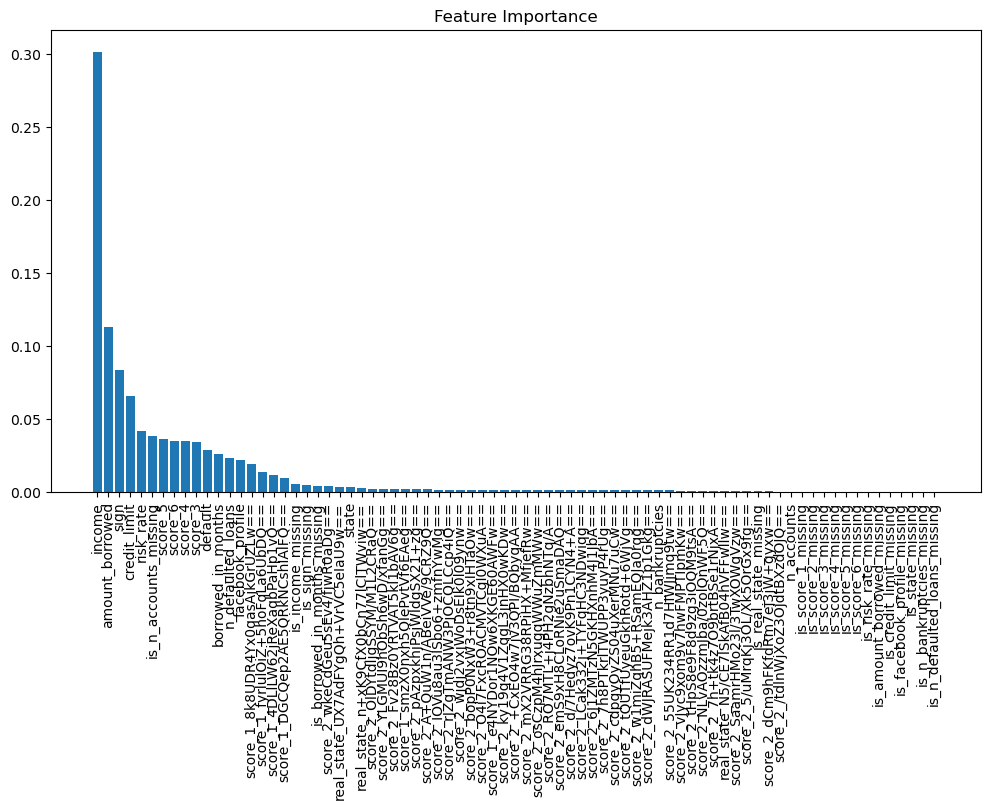

In [7]:
clf = RandomForestClassifier(n_estimators=250, max_depth=10, random_state=0, max_features=25, oob_score=True)

skf = StratifiedKFold( 5, shuffle=True, random_state=100)
cm = np.zeros((2,2))
aucs = []
for (fold, (i_train, i_test)) in enumerate(skf.split(X_train,y_train)):
    clf.fit(X_train.iloc[i_train], y_train.iloc[i_train])
    i_pred_proba = clf.predict_proba(X_train.iloc[i_test])
    pred = clf.predict(X_train.iloc[i_test])
    print(i_pred_proba.shape)
    auc = metrics.roc_auc_score(y_train.iloc[i_test], i_pred_proba[:, 1])
    aucs.append(auc)
    
    cm += metrics.confusion_matrix(y_train.iloc[i_test],pred)
    print("AUC score on fold %i: %2.3f" % (fold, auc))
print("AUC: %2.3f +- %2.4f" % (np.mean(aucs), np.std(aucs)))
print("\nConfusion matrix:")
print(cm)
print("\nAccuracy %2.3f" %(cm.diagonal().sum()/cm.sum()))

clf.fit(X_train,y_train)
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, indices.size + 1), importances[indices], align="center")
plt.xticks(range(1, indices.size + 1),
           df_train.columns[indices],
           rotation=90)
plt.title("Feature Importance")
plt.show()

c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\p

(11994, 2)
AUC score on fold 0: 0.758


c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\p

(11993, 2)
AUC score on fold 1: 0.762


c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\p

(11993, 2)
AUC score on fold 2: 0.759


c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\p

(11993, 2)
AUC score on fold 3: 0.768


c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\p

(11993, 2)
AUC score on fold 4: 0.765
AUC: 0.762 +- 0.0037

Confusion matrix:
[[36417. 14039.]
 [ 3192.  6318.]]

Accuracy 0.713


c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\p

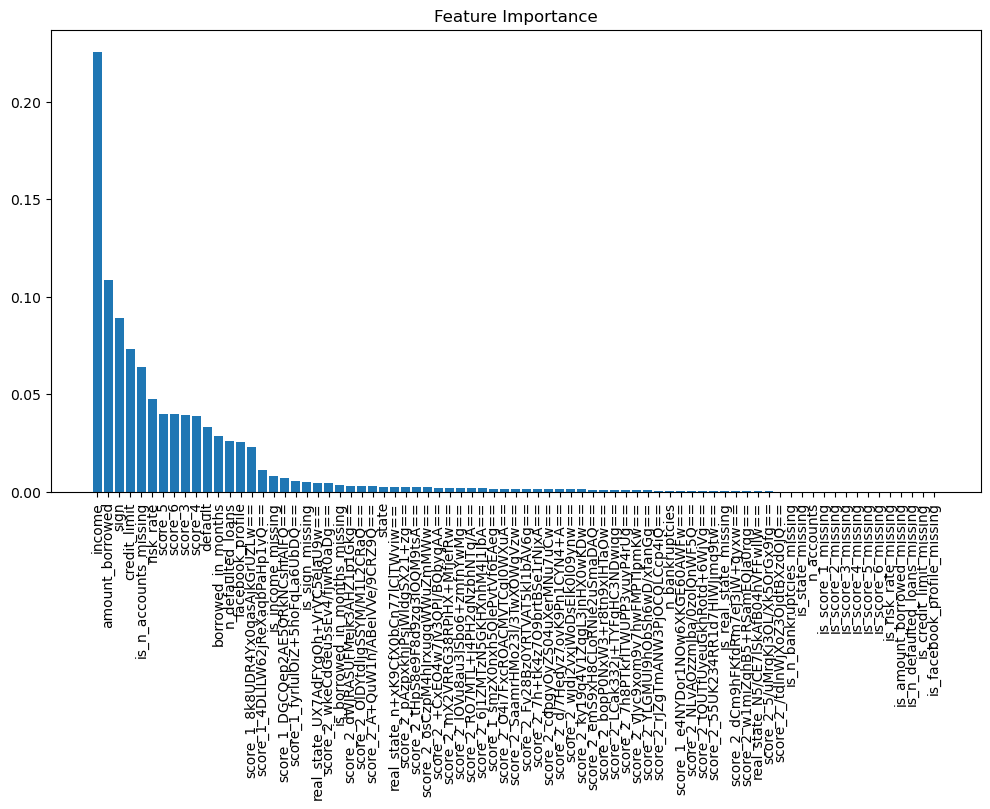

In [8]:
clf2 = BalancedRandomForestClassifier(n_estimators=250, max_depth=10,random_state=0,max_features=25, oob_score=True)

cm2 = np.zeros((2,2))
aucs2 = []
for (fold, (i_train, i_test)) in enumerate(skf.split(X_train,y_train)):
    clf2.fit(X_train.iloc[i_train], y_train.iloc[i_train])
    i_pred_proba = clf2.predict_proba(X_train.iloc[i_test])
    pred = clf2.predict(X_train.iloc[i_test])
    print(i_pred_proba.shape)
    auc = metrics.roc_auc_score(y_train.iloc[i_test], i_pred_proba[:, 1])
    aucs2.append(auc)
    
    cm2 += metrics.confusion_matrix(y_train.iloc[i_test],pred)
    print("AUC score on fold %i: %2.3f" % (fold, auc))
print("AUC: %2.3f +- %2.4f" % (np.mean(aucs2), np.std(aucs2)))
print("\nConfusion matrix:")
print(cm2)
print("\nAccuracy %2.3f" %(cm2.diagonal().sum()/cm2.sum()))

clf2.fit(X_train,y_train)
importances2 = clf2.feature_importances_

indices = np.argsort(importances2)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, indices.size + 1), importances2[indices], align="center")
plt.xticks(range(1, indices.size + 1),
           df_train.columns[indices],
           rotation=90)
plt.title("Feature Importance")
plt.show()

In [9]:
clf2.fit(X_train, y_train)
my_predictions = pd.DataFrame(clf.predict_proba(X_test)[:, 1], columns=["predictions"], index=X_test.index)
my_predictions.to_csv("predictions.csv")
my_predictions

c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\rober\anaconda3\envs\TML\lib\site-packages\sklearn\utils\p

,predictions
ids,
e4366223-7aa2-0904-7a47-66479ae46b2a,0.111833
c6416108-c6d7-e6be-c4b5-923dd36c8ec4,0.261568
a90d3929-86ec-2414-89ba-543776b0e82b,0.151208
c5b96a7f-389a-28d0-242d-95db05e69da0,0.465195
1b461faa-926d-565d-b15d-0b452968ac81,0.232135
...,...
cfe269ae-b893-c084-f9f5-3b91f9725b71,0.138795
2feff27a-3dcf-1e19-7583-a8eab192fd23,0.072438
601509fd-20d9-d3b8-b143-defcf5457d2c,0.136126
